# Topic modeling with Latent Dirichlet Allocation and NMF

This is a unsupervised learning method to create topics from a copus of texts.  
Note that topics are more flexible than clusters, as one documents could have multiple topics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap
import math
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

we are creating a set of stop words that we can iteratively contribute too when we get a first look at the words in out topics.  
If we find commong words in our topics, we can put them as stop words and make to topics more relevant.

In [2]:
stop_words = set(stopwords.words('english'))


In [3]:
stop_words = stop_words.union({
    'also'
})
stops = list(stop_words) # required for later version of CountVectorizer

Let's get our dataset

In [4]:
df = pd.read_csv('../datasets/bbc/bbc_text_cls.csv')

In [5]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [6]:
vectorizer = CountVectorizer(stop_words=stops)

In [7]:
X = vectorizer.fit_transform(df['text'])

Let's now instantiate our LDA model

In [8]:
nbr_of_topics = 12
lda = LatentDirichletAllocation(
    n_components=nbr_of_topics, # default: 10
    random_state=42,
)

In [9]:
Z = lda.fit_transform(X)

Let's plot the top 10 words associated with each topics.  
The following function is taken from sklearn documentation

In [10]:
def plot_top_words(model, feature_names, n_top_words=10, nbr_of_topics=nbr_of_topics):
  fig, axes = plt.subplots(math.ceil(nbr_of_topics/5), 5, figsize=(30, 15), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle('LDA', fontsize=40)

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()

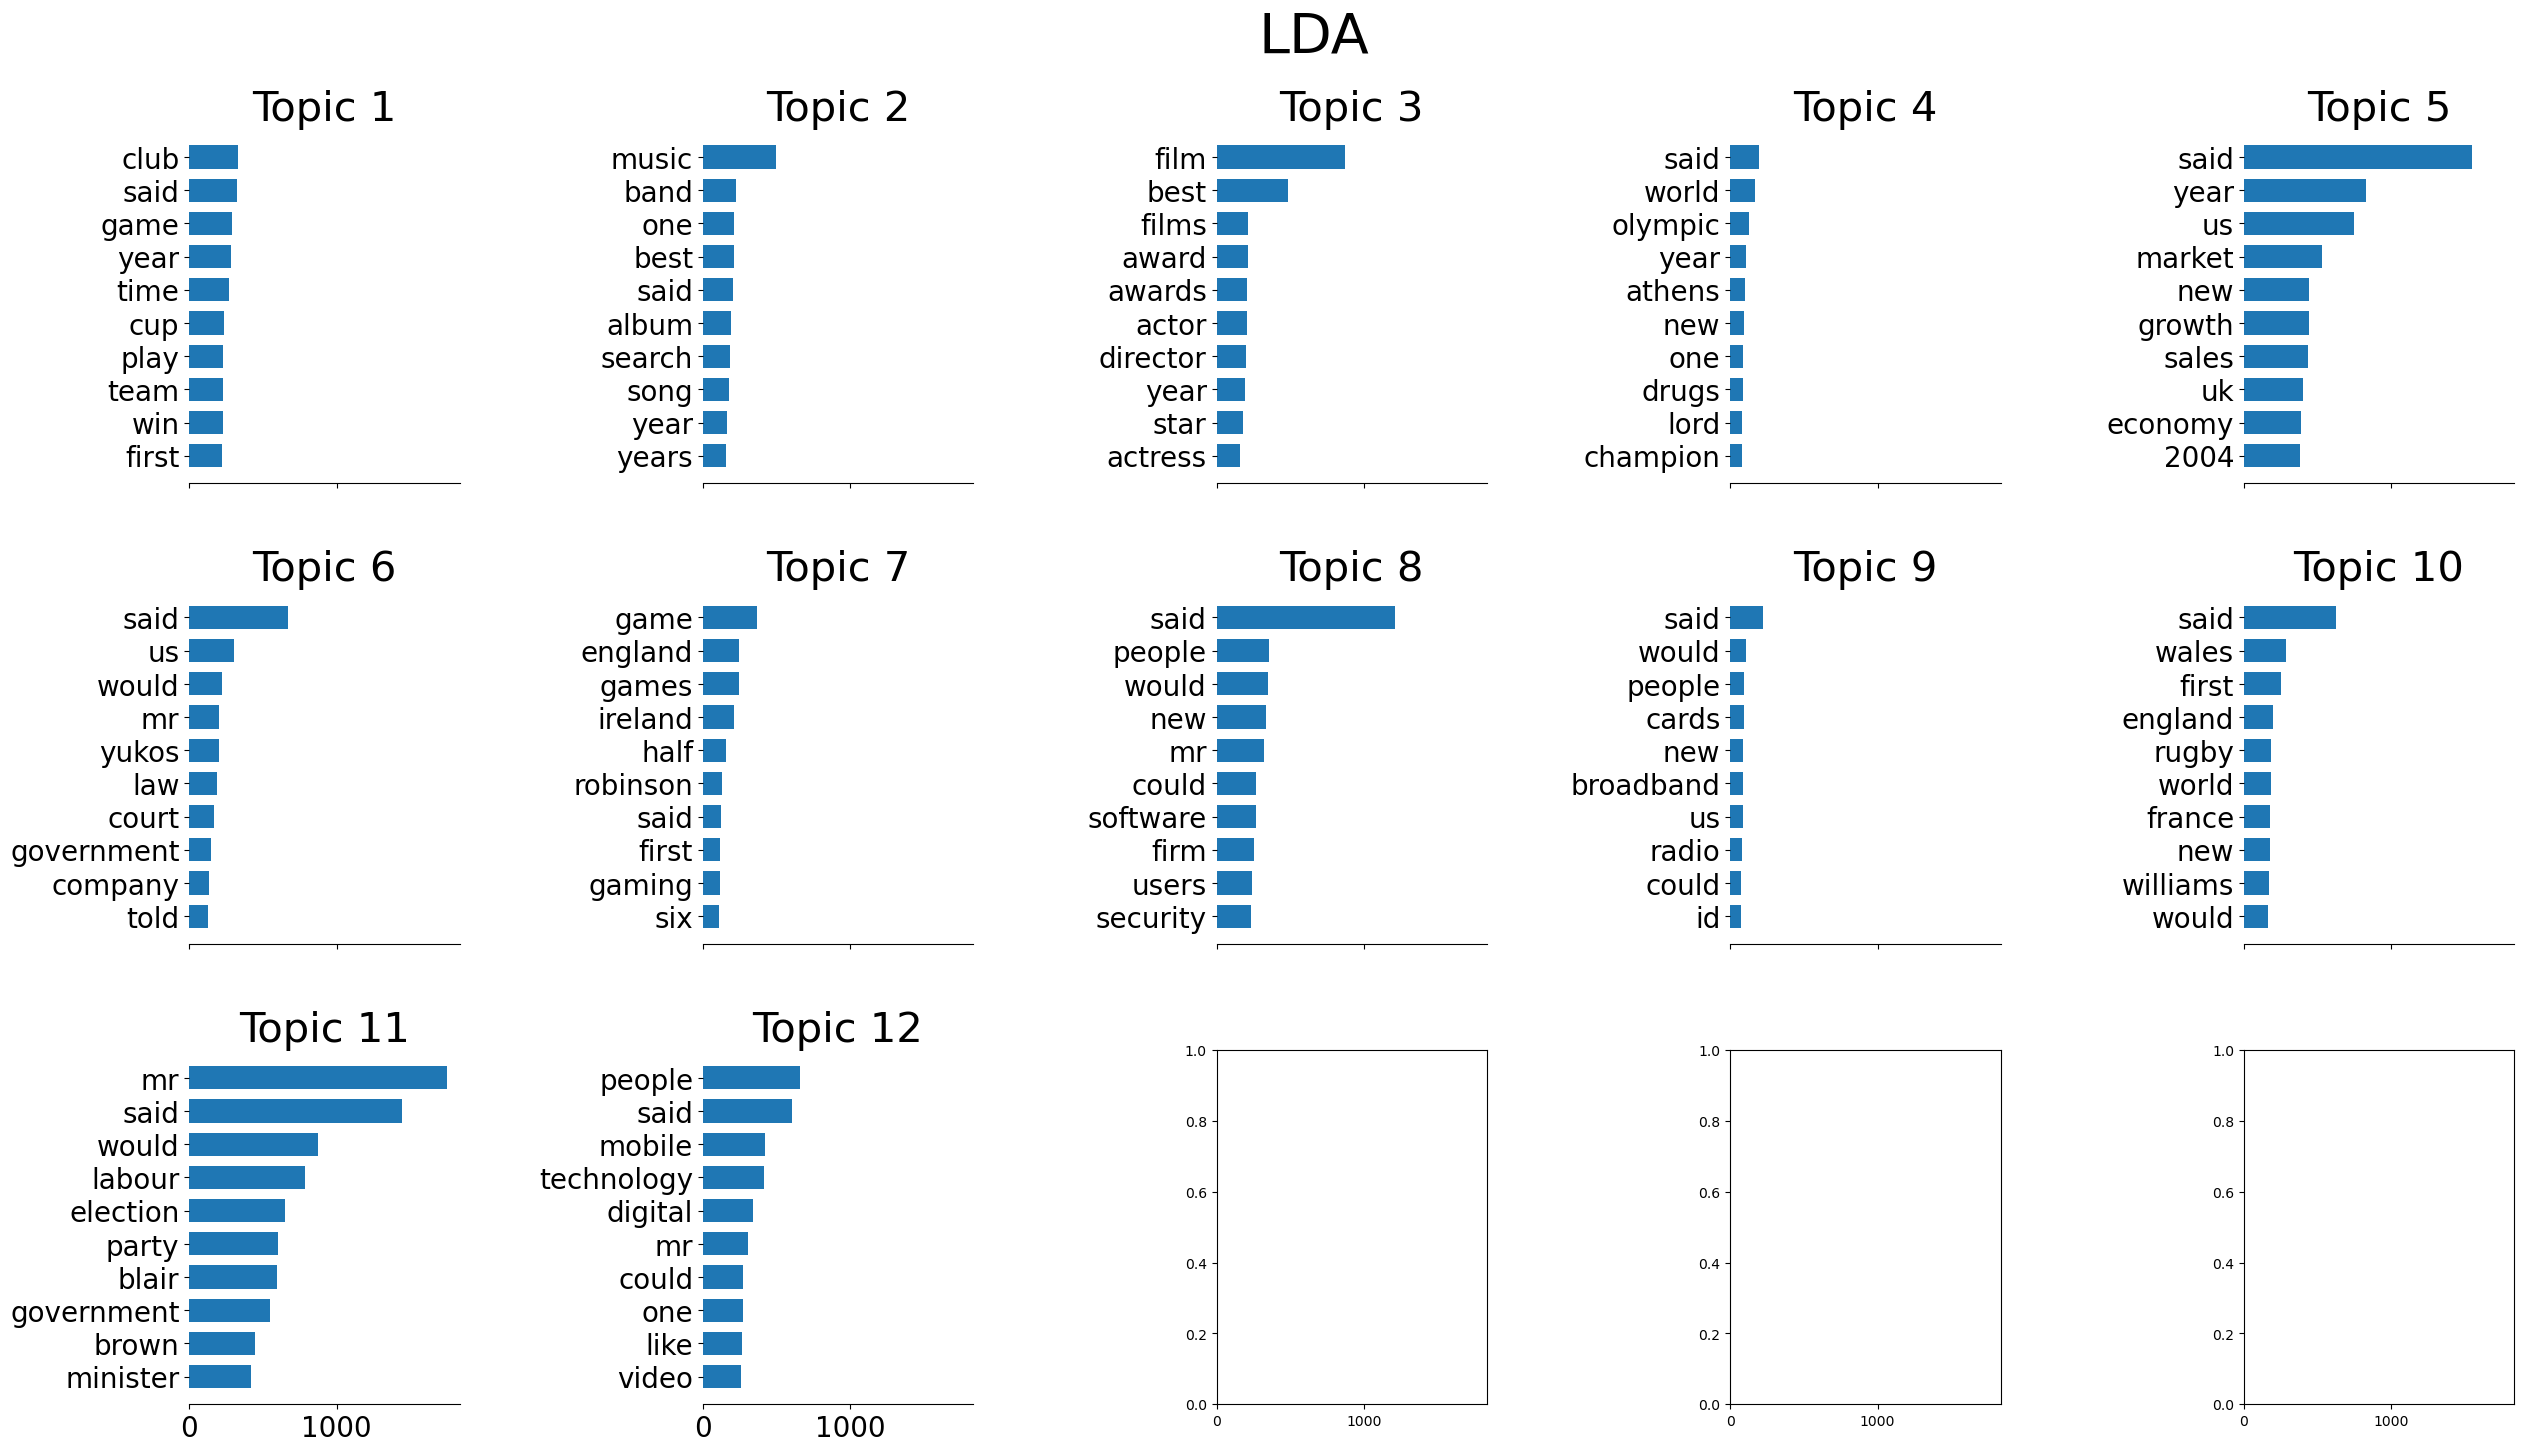

In [11]:
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names);


### Iteration on the stop words

it looks like the words 'said', 'mr', 'would', 'could', 'year', 'new' are occuring in many different topics. Thus making them irrelevant. Let's add them to our stop words.

In [12]:
stop_words = stop_words.union({
    'also','said', 'would', 'could', 'told', 'one', 'two',
    'mr', 'new', 'year', 'people', 'get', 'like',
    'says'
})
stops = list(stop_words)

Now let's run the whole sequence again

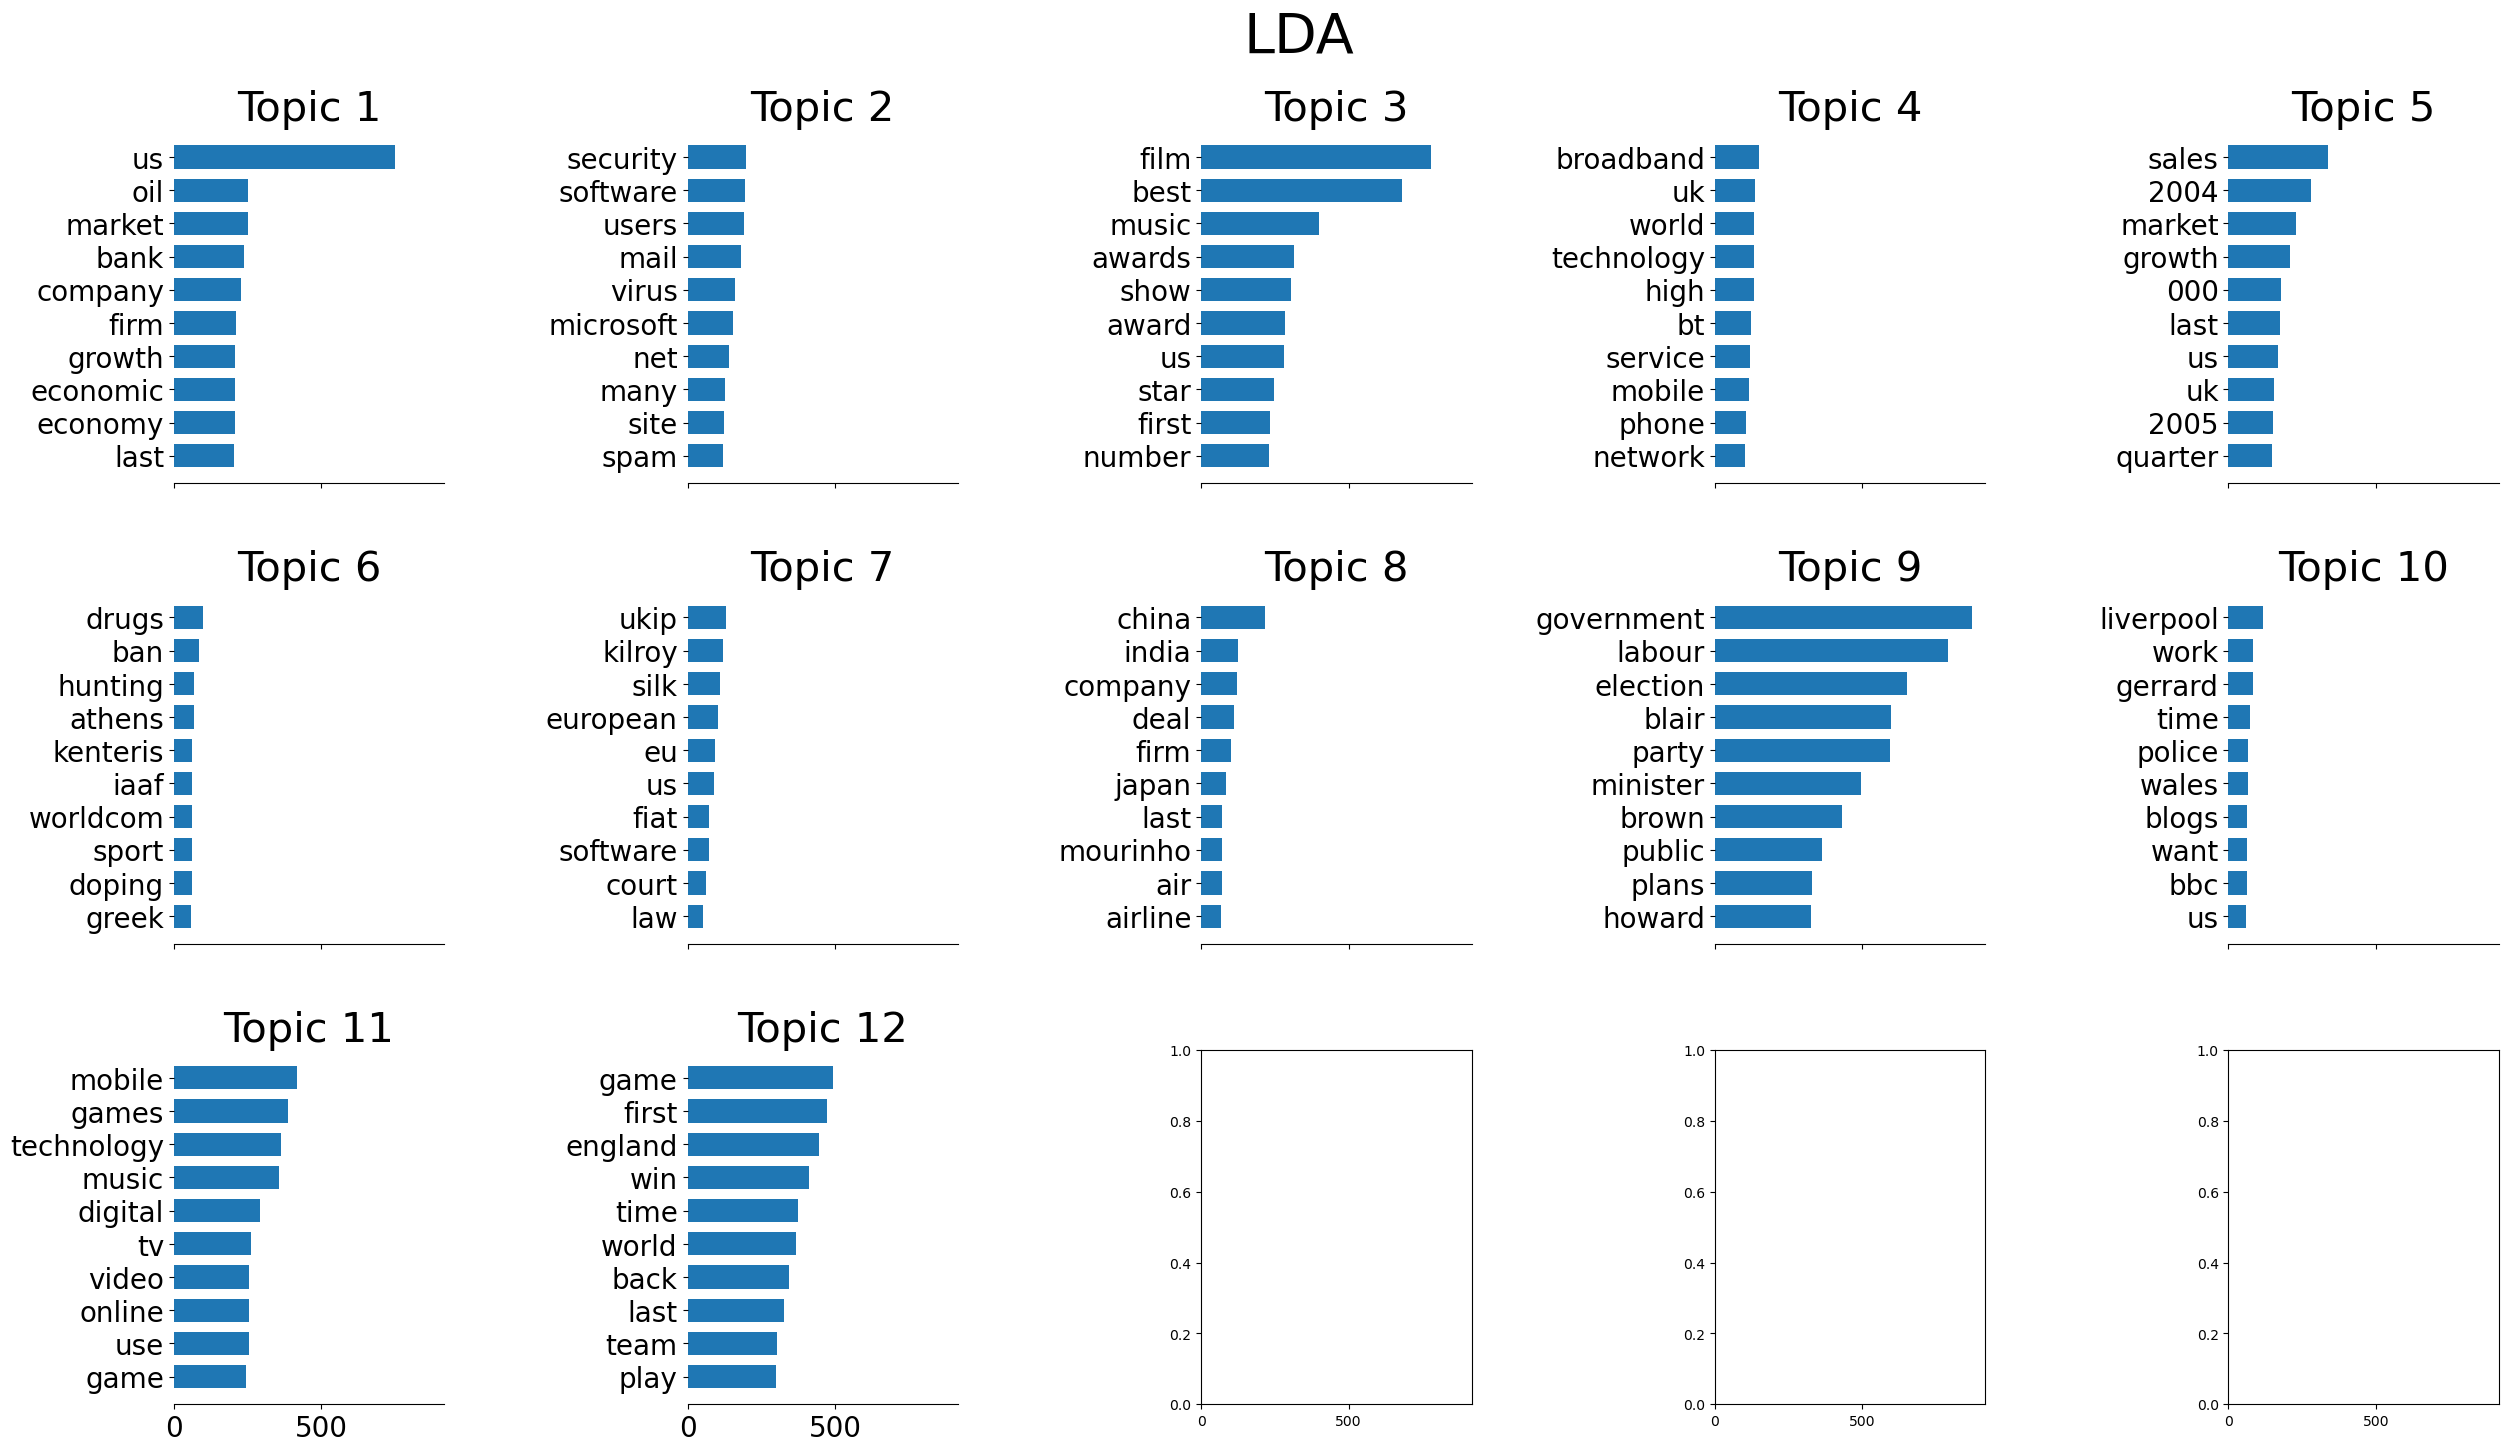

In [13]:
vectorizer = CountVectorizer(stop_words=stops)
X = vectorizer.fit_transform(df['text'])
Z = lda.fit_transform(X)
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names);

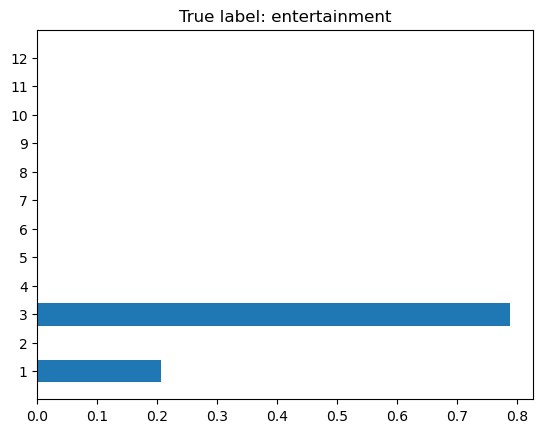

In [14]:
# Pick a random document
# Check which "topics" are associated with it
# Are they related to the true label?

#np.random.seed(42)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(nbr_of_topics) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels']);

In [15]:
def wrap(x):
  return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

#Let's print the article in question:
print(wrap(df.iloc[i]['text']))

Rapper 50 Cent scores chart first

Rapper 50 Cent has become the first
solo artist to have three singles in the US top five in the same week.
His track Candy Shop remained at the top of the charts, while Disco
Inferno crept up from six to five.  50 Cent also appears on rap
protege The Game's song How We do, number four in the US but now
outside the UK top ten.  The pair had a recent dispute which saw The
Game thrown out of 50 Cent's rap collective G-Unit, accusing him of
disloyalty in an ongoing feud.

50 Cent, who burst onto the music
scene in 2003, has had less success in the UK charts, with three
singles making the top ten.  His debut album, Get Rich And Die Tryin',
narrowly missed out on becoming a UK chart topper.

But in the US, he
headed the 2003 end of year charts for the album and R&B and hip hop
artists.  Newcomer The Game's debut reached the top of the charts five
weeks ago, while 50 Cent's second collection The Masscre was released
in the US at the end of last week.  Last M

# We can also do topic modeling with Non-Negative Matrix Factorization

In [17]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
vectorizer = TfidfVectorizer(stop_words=stops)
X = vectorizer.fit_transform(df['text'])

In [22]:
nmf = NMF(
    n_components=nbr_of_topics, # default: 10
    beta_loss="kullback-leibler",
    solver='mu',
    # alpha_W=0.1,
    # alpha_H=0.1,
    # l1_ratio=0.5,
    random_state=0,
)

In [23]:
Z = nmf.fit_transform(X)

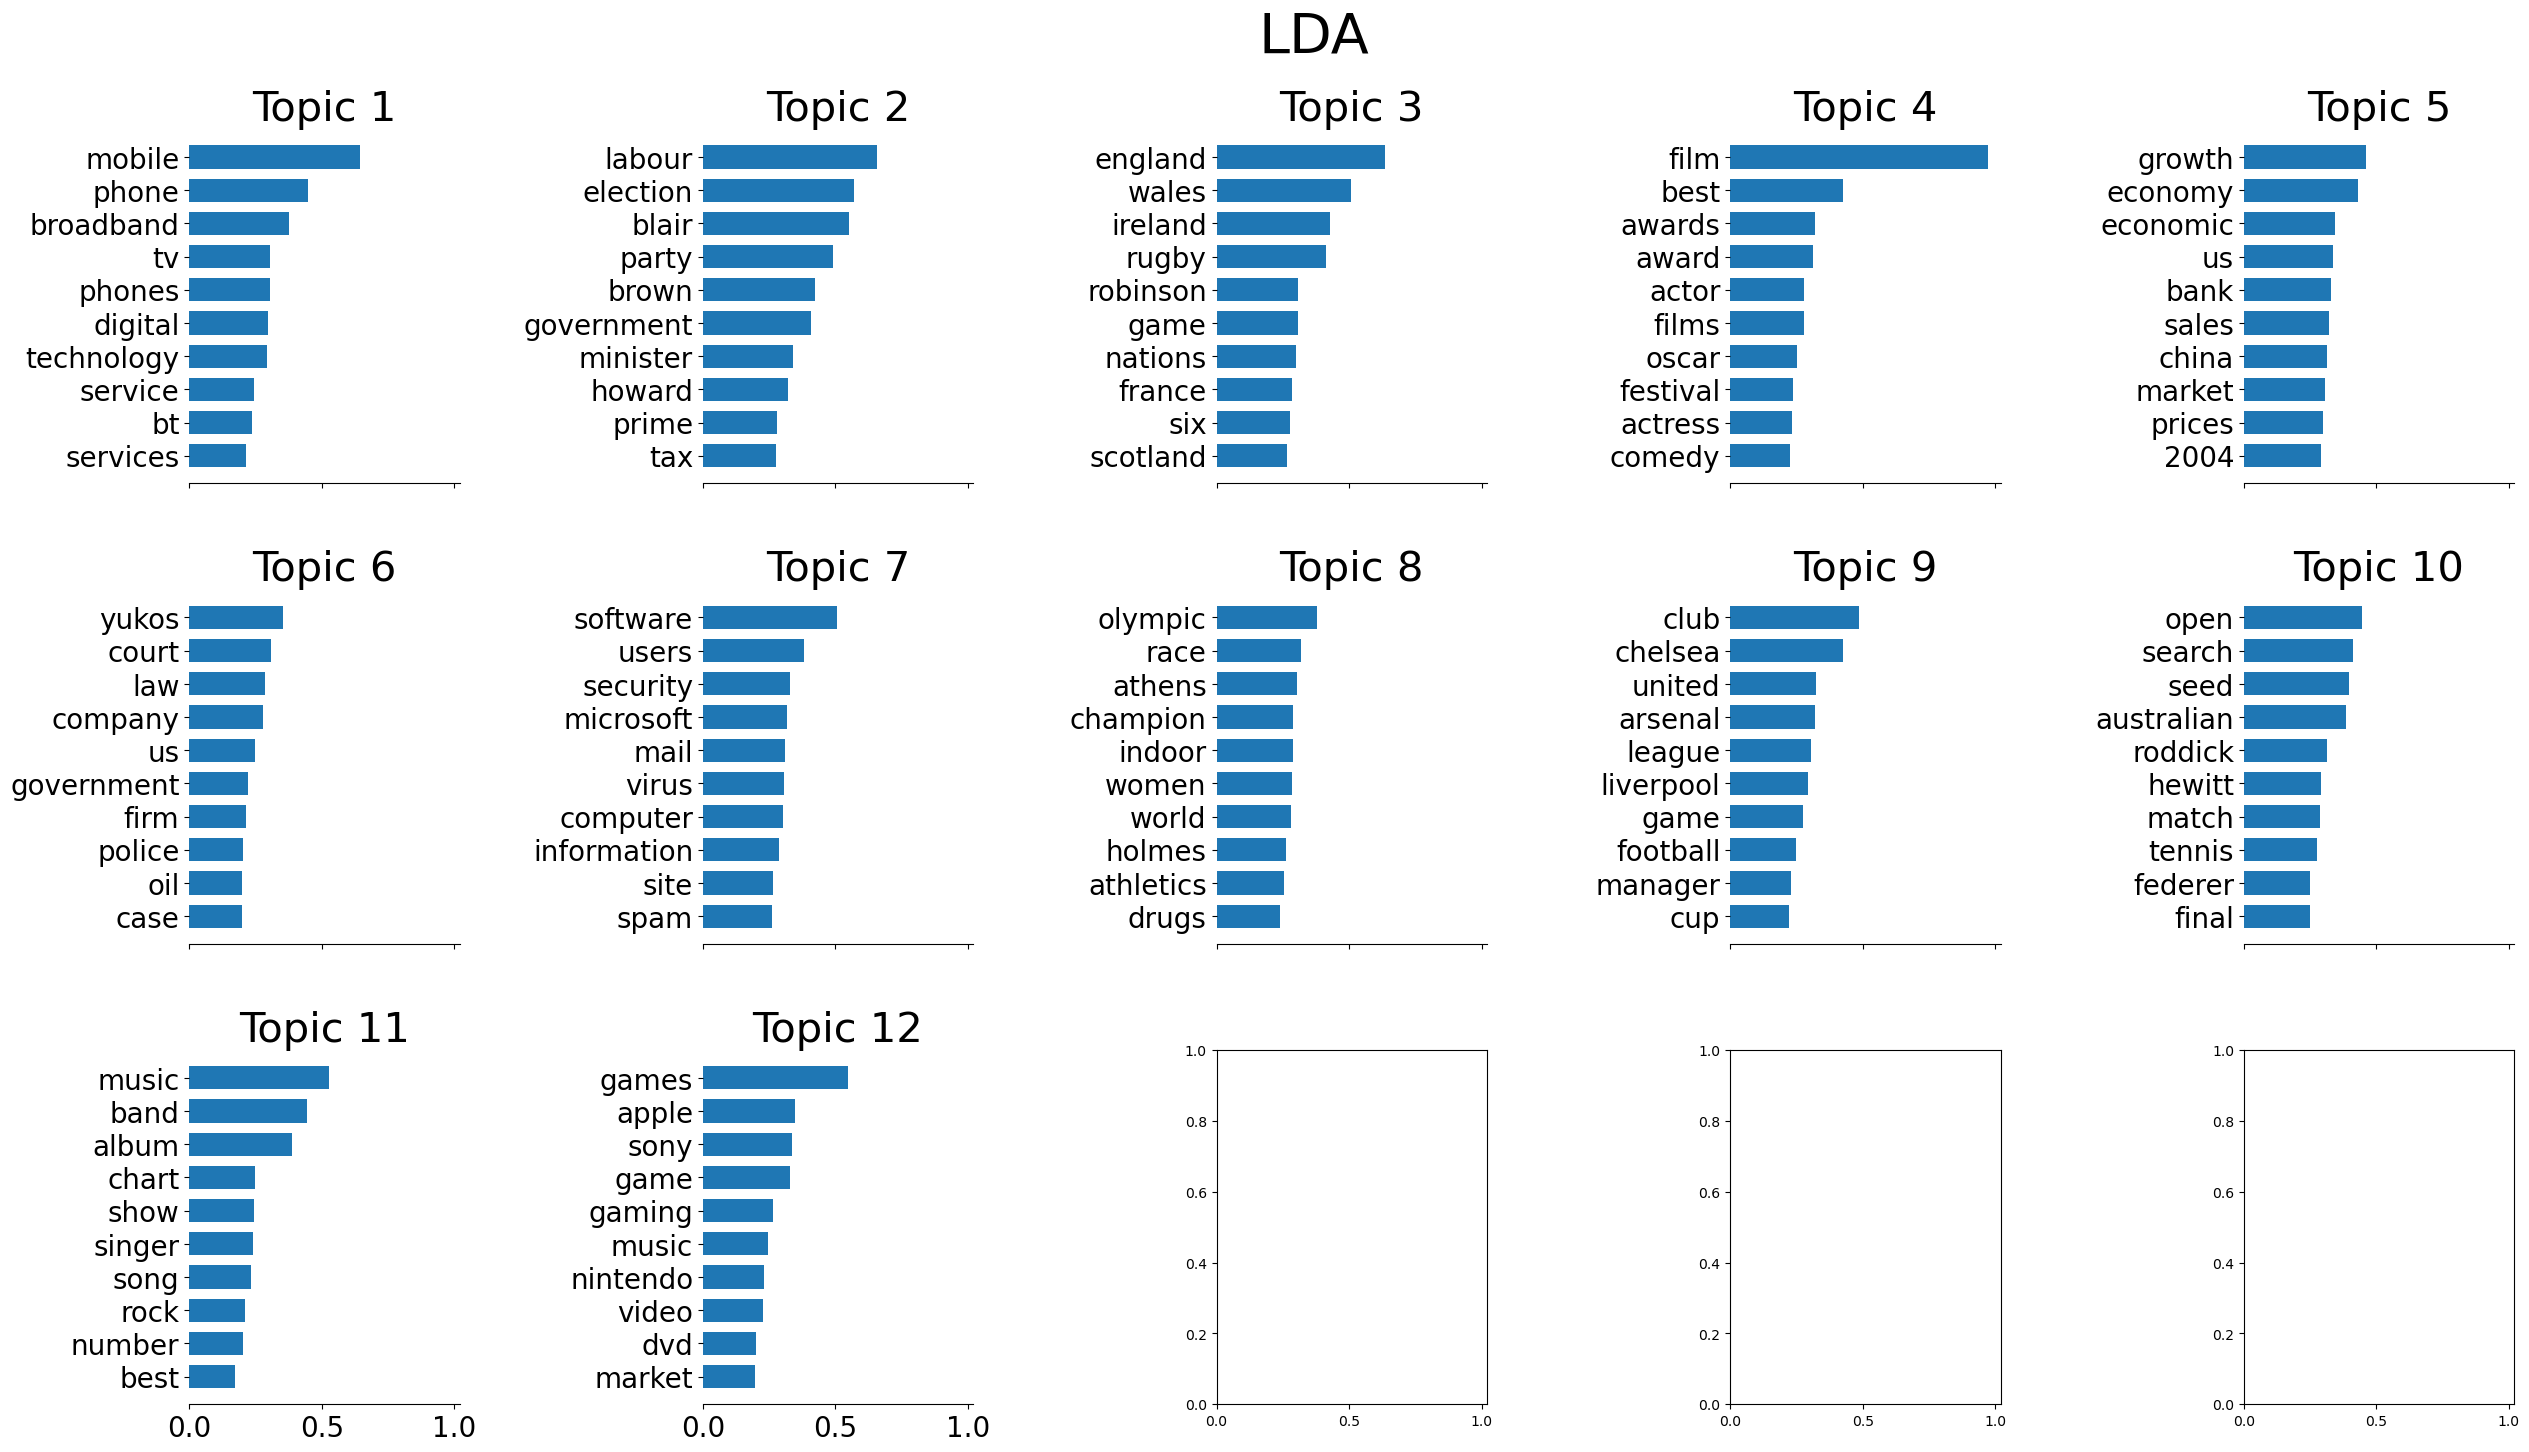

In [24]:
feature_names = vectorizer.get_feature_names_out()
plot_top_words(nmf, feature_names);

Applegate's Charity show closes

US musical Sweet Charity has
cancelled its run on Broadway after poor ticket sales for its early
shows.

Star Christina Applegate had to pull out of pre-Broadway
performances earlier this month with a broken foot.  Producer Barry
Weissler said he was "deeply proud" of the show, but said the decision
to close it was "painful but fiscally responsible". Applegate, who
starred in TV comedy Married With Children, had been hoping to make
her Broadway debut in the show.  The 33-year-old injured herself while
performing in Chicago, and had been hoping to recover in time for its
official New York opening on 21 April.  She had received mixed reviews
for performances in Minneapolis and Chicago.  Previews of the $7.5m
(£4m) show were due to begin on 4 April.  Sweet Charity tells the
story of Charity Hope Valentine, a dancer who always falls in love
with the wrong man.  It was first performed on Broadway in 1966 with
Gwen Verdon in the title role, while Shirley MacL

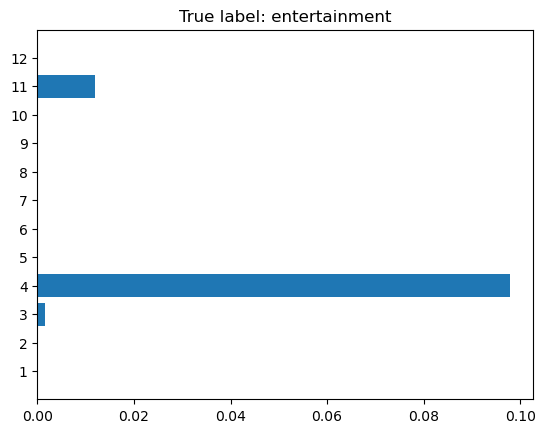

In [25]:
# Pick a random document
# Check which "topics" are associated with it
# Are they related to the true label?

#np.random.seed(42)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(nbr_of_topics) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels']);

#Let's print the article in question:
print(wrap(df.iloc[i]['text']))